In [ ]:
# (c) Westerveld 2023
# final project - watermark remover
# Display of watermark remover autoencoder, takes image file and displays before and after

In [ ]:
# downloads zipped dataset and extracts, takes about 4 mins
#commented out because this is not needed unless testing the dataste specifically

!gdown 17y1gkUhIV6rZJg1gMG-gzVMnH27fm4Ij

!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive("CLWD.rar").extractall("")

Downloading...
From (original): https://drive.google.com/uc?id=17y1gkUhIV6rZJg1gMG-gzVMnH27fm4Ij
From (redirected): https://drive.google.com/uc?id=17y1gkUhIV6rZJg1gMG-gzVMnH27fm4Ij&confirm=t&uuid=edfba5d5-fd4c-4cd3-883c-787b2c5f30cb
To: /content/CLWD.rar
100% 3.35G/3.35G [01:13<00:00, 45.5MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
# install what is the best model so far from google drive

!gdown 1FOk6nV1x2cGB8iCnnMHWEg-gcVb5F0eQ

Downloading...
From: https://drive.google.com/uc?id=1FOk6nV1x2cGB8iCnnMHWEg-gcVb5F0eQ
To: /content/save_epoch-5.pth
100% 5.69M/5.69M [00:00<00:00, 41.4MB/s]


In [ ]:

# import libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.io import read_image
from PIL import Image
import torchvision.transforms as T
import random

In [ ]:
# custom dataset - returns watermarked image as image, and watermark free as label.

class Watermark_Dataset(Dataset):

  def __getitem__(self, idx):
      # get watermarked and corresponding watermark free image
      img_path = r"CLWD/train/Watermarked_image/" + str(idx + 1) + ".jpg"
      watermarked = Image.open(img_path).convert('RGB')
      img_path = r"CLWD/train/Watermark_free_image/" + str(idx + 1) + ".jpg"
      watermark_free = Image.open(img_path).convert('RGB')

      # convert to tensor
      transform_one = T.ToTensor()

      img = transform_one(watermarked)
      label = transform_one(watermark_free)

      # return img and label
      return img.float(), label.float()

  def __len__(self):
    #hardcoded length - number of watermarked/watermark free image pairs in datset
    return 60_000

# New Section

epoch: 5
Loss: tensor(0.0086, device='cuda:0', requires_grad=True)
286


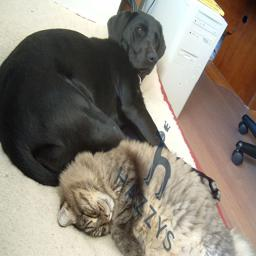

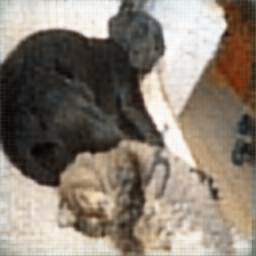

In [ ]:
# Model class - convolutional autoencoder
# scales down image with encoding which is then decoded with decoder.
# takes in 256x256 JPG images and returns 256x256 JPG images (has 3 channels for RGB)

class Auto_Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    # encoder - compresses the image
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, 3, stride = 2, padding = 1),
        nn.LeakyReLU(0.1),
        nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
        nn.LeakyReLU(0.1),
        nn.Conv2d(32, 64, 7),

    )

    # max pooling - takes max of the pixels in an area to compress
    self.pool = nn.MaxPool2d(2, stride=2, return_indices=True)
    self.unpool = nn.MaxUnpool2d(2, stride=2)

    # decoder - decompresses
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(16, 3, 3, stride = 2, padding = 1, output_padding = 1),
        nn.Sigmoid()

    )
  # output
  def forward(self, x):

    encoded = self.encoder(x)

    # pooling and unpooling
    output, indices = self.pool(encoded)
    unpooled = self.unpool(output, indices)

    decoded = self.decoder(unpooled)
    return decoded

#initialize model
model = Auto_Encoder()

# load model from file
checkpoint = torch.load('save_epoch-5.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# print epoch and loss
epoch = checkpoint['epoch']
print("epoch:", str(epoch))
loss = checkpoint['loss']
print("Loss:", str(loss))

# prepare to evaluate and not trianing - allow to take single image instead of batch, among other things
model.eval()


# just for demonstration it picks random image from dataset, but any image can be used by changing image path
idx = random.randint(1, 5_000)
path = r"CLWD/test/Watermarked_image/"+ str(idx) +".jpg"
im = Image.open(path)
im = im.resize((256, 256))
print(idx)

# show initial
display(im)#.show()



# convter to float tensor to pass through the model
transform = T.Compose([T.ToTensor()])
img_tensor = transform(im)
img_tensor = img_tensor.float()

# run input through the model
output = model(img_tensor)

path = r"CLWD/test/Watermark_free_image/"+ str(idx) +".jpg"
im = Image.open(path)
im = im.resize((256, 256))

#display(im)#.show()

# dipslay image using Pillow
transform = T.ToPILImage()
img = transform(output)
display(img)#.show()

In [ ]:
# Testing dataset - display watermarked and watermark free image
# mostly for bugfixing
Train_Data = Watermark_Dataset()
train_dataloader = DataLoader(Train_Data, batch_size=4, shuffle=True)

# iterate features and labels
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# get first image of the batch
img = train_features[0]
label = train_labels[0]

# convert to image and display both
pic1 = transform(img)
pic1.show()
pic2 = transform(label)
pic2.show()

Feature batch shape: torch.Size([4, 3, 256, 256])
Labels batch shape: torch.Size([4, 3, 256, 256])
